# OMAE2020-4810, suplemental notebook

This notebook is released in relation to OMAE2020-4810 *CONTINUOUS DRILLING SENSOR DATA RECONSTRUCTION ANDPREDICTION VIA RECURRENT NEURAL NETWORKS* publication. Source code is published on CC BY-NC-SA 4.0 license.

This is a suplemental notebook used for the modified method of inclination change prediction. Data is shared between the notebooks using binary .npy file.

Andrzej Tunkiel

University of Stavanger

In [1]:
import warnings
warnings.filterwarnings('ignore')

url = 'https://raw.githubusercontent.com/AndrzejTunkiel/atunkiel_open/master/F9ADepth.csv'

from numpy.random import seed
seed(42)
from tensorflow import set_random_seed
set_random_seed(42)



In [2]:
%matplotlib inline
from pylab import rcParams
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
from pandas import datetime
import numpy as np
from pandas.plotting import autocorrelation_plot
import statsmodels as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,  plot_pacf
from statsmodels.tsa.statespace import sarimax

from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.layers import Bidirectional
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import CuDNNGRU
from keras.layers.core import Reshape
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.utils import plot_model
from keras.layers import Dense, Dropout, Input, concatenate, Add
from keras.models import load_model

from keras import Model, Input
from keras.layers import (LSTM, Dense, Activation, BatchNormalization, 
                      Dropout, Bidirectional, Add, Flatten, GaussianNoise)

from keras.layers import Dense, LSTM, GlobalMaxPooling1D, MaxPooling1D

from keras import optimizers

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from sklearn.kernel_ridge import KernelRidge
from sklearn import svm
from sklearn import linear_model
from sklearn.neighbors import  RadiusNeighborsRegressor
from sklearn.model_selection import train_test_split


df_dl = pd.read_csv('F9ADepth.csv')

Using TensorFlow backend.


In [3]:
rcParams['figure.figsize'] = 11,5



In [4]:
def sampling_fix(df,name,start,stop,radius,medianFilter,plot):
    #Filter dataset based on depth range
    df = df[(df['Measured Depth m'] > start) & (df['Measured Depth m'] < stop) ]
    #remove NaNs from dataset
    df = df[np.isfinite(df[name])]
    X = df['Measured Depth m']
    
    #reshape the depth to matcch regressor requirements
    X = X.values.reshape(X.shape[0],1)
    
    #define regressor with provided radius
    reg = RadiusNeighborsRegressor(radius=radius, weights='uniform')
    
    #apply median filter with back filling (to remove NaNs at the beginning of dataset)
    y = df[name].rolling(medianFilter).median().bfill()
    
    #fit regressor
    reg.fit(X, y)
    
    #check if plotting was required or should the model be returned
    if plot == 0:
        return reg
    else:
        #plot the chart. Original data is plotted as well as the regression data.
        plt.scatter(X,y, label=name)
        plt.plot(X, reg.predict(X),c='r',label="prediction")
        plt.legend()
        plt.show()


def prepareinput(data, memory_local):
    memory = memory_local
    stack = []
    for i in range(memory):
        stack.append(np.roll(data, -i))

    X_temp = np.hstack(stack)


    
    X = X_temp
    return X


def prepareinput_nozero(data, memory_local, predictions):
    memory = memory_local
    stack = []
    for i in range(memory+predictions):
        stack.append(np.roll(data, -i))

    X = np.hstack(stack) 
    return X


def prepareoutput(data, memory_local, predictions):
    memory = memory_local
    stack = []
    for i in range(memory, memory+predictions):
        stack.append(np.roll(data, -i))

    X = np.hstack(stack)
    return X


    
def mymanyplots(epoch, data, model):
    
    
    [X1, X2, X3, X4, y, X1_train,X_train, X_test, X1_test, border1, border2, y_train, y_test, memory, y_temp, predictions] = data

    Xtrain = model.predict(X_train)
    Xtest = model.predict(X_test)
    
    rcParams['figure.figsize'] = 11, 5

    

    for i in range(1):
        shape = (7,1)
        fig = plt.figure()
        fig.tight_layout()
        fig.subplots_adjust(hspace = 1)
        ax1 = plt.subplot2grid(shape, (0,0), rowspan=4)    
        ax2 = plt.subplot2grid(shape, (4,0), sharex=ax1)
        ax3 = plt.subplot2grid(shape, (5,0), sharex=ax1)    
        ax4 = plt.subplot2grid(shape, (6,0), sharex=ax1)
        
        for ax in fig.axes:
            plt.setp(ax.get_xticklabels(), visible=False)


        known_attributes = ['Average Surface Torque kN.m', 'Average Rotary Speed rpm', 'Rate of Penetration m/h']

        i=0
        for axe in fig.axes:
            if i == 0:
                tr = np.random.randint(0, border1)
                axe.plot(np.arange(memory,memory+predictions,1),y_train[tr],linewidth=5,alpha=0.5,c='b', label='training input')
                axe.plot(np.arange(0,memory,1),X1_train[tr], linewidth=5,alpha=0.5, c='g' , label="training expected")
                axe.plot(np.arange(memory,memory+predictions,1),Xtrain[tr],c='r', label='training predicted')
                axe.set_title('Training results')
                axe.set_facecolor('xkcd:light blue')
                axe.legend()

            else:

                axe.plot(np.arange(0,memory+predictions,1),X_train[1][tr,:,i-1],label=known_attributes[i-1]) 
                axe.set_facecolor('xkcd:ivory')
                axe.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
               ncol=2, mode="expand", borderaxespad=0.)
            i = i + 1
        plt.show()

    for i in range(3):
        shape = (7,1)
        fig = plt.figure()
        fig.tight_layout()
        fig.subplots_adjust(hspace = 1)
        ax1 = plt.subplot2grid(shape, (0,0), rowspan=4)    
        ax2 = plt.subplot2grid(shape, (4,0), sharex=ax1)
        ax3 = plt.subplot2grid(shape, (5,0), sharex=ax1)    
        ax4 = plt.subplot2grid(shape, (6,0), sharex=ax1)
        
        for ax in fig.axes:
            plt.setp(ax.get_xticklabels(), visible=False)

        known_attributes = ['Average Surface Torque kN.m', 'Average Rotary Speed rpm', 'Rate of Penetration m/h']

        i=0
        for axe in fig.axes:
            if i == 0:
                tr = np.random.randint(0, border2 - border1)
                axe.plot(np.arange(memory,memory+predictions,1),y_test[tr],linewidth=5,alpha=0.5,c='b', label='testing input')
                axe.plot(np.arange(0,memory,1),X1_test[tr], linewidth=5,alpha=0.5, c='g' , label="testing expected")
                axe.plot(np.arange(memory,memory+predictions,1),Xtest[tr],c='r', label='testing predicted')
                axe.set_title('Testing results')
                axe.set_facecolor('xkcd:light grey')
                axe.legend()

            else:

                axe.plot(np.arange(0,memory+predictions,1),X_test[1][tr,:,i-1],label=known_attributes[i-1]) 
                axe.set_facecolor('xkcd:ivory')
                axe.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
               ncol=2, mode="expand", borderaxespad=0.)
            i = i + 1
        plt.show()

        
def myerrorplots(data, model):
    
    
    [X1, X2, X3, X4, y, X1_train,X_train, X_test, X1_test, border1, border2, y_train, y_test, memory, y_temp, predictions] = data



In [5]:
def hyperparameter (matrix):
    
    [start, stop, inc_layer1,inc_layer2,data_layer1,data_layer2,dense_layer,range_max,memory, predictions, drop1, drop2] = matrix
    drop1 = drop1/100
    drop2 = drop2/100
    inc_layer2 = inc_layer2/1000

    df = df_dl # pd.read_csv('F9ADepth.csv')

    start = start
    stop = stop
    step = 0.230876

    X = np.arange(start,stop,step)
    X = X.reshape(X.shape[0],1)



    %matplotlib inline
    rcParams['figure.figsize'] = 10, 5

    X = np.arange(start,stop,step)
    X = X.reshape(X.shape[0],1)

    my_data1 = sampling_fix(df, 'MWD Continuous Inclination dega',start,stop,1.7,1,0).predict(X)
    my_data2 = sampling_fix(df, 'Average Surface Torque kN.m',start,stop,1.7,3,0).predict(X)
    my_data3 = sampling_fix(df, 'Average Rotary Speed rpm',start,stop,1.7,3,0).predict(X)
    my_data4 = sampling_fix(df, 'Rate of Penetration m/h',start,stop,0.5,1,0).predict(X)

    data_array = np.asarray([my_data1, my_data2, my_data3, my_data4])

    dftemp = pd.DataFrame()
    dftemp['dinc'] = my_data1
    dftemp['dinc'] = dftemp['dinc'].diff(1).rolling(3).mean(center=True)

    my_data1 = dftemp['dinc'].ffill().bfill()

    my_data1 = my_data1[:,np.newaxis]
    my_data2 = my_data2[:,np.newaxis]
    my_data3 = my_data3[:,np.newaxis]
    my_data4 = my_data4[:,np.newaxis]


    temp_data1 = pd.DataFrame(my_data1.flatten())

    range1 = temp_data1[0].diff(memory+predictions)
    
    
    range2 = np.amax(range1)

    
    
    scaler1 = MinMaxScaler()
    scaler2 = MinMaxScaler()
    scaler3 = MinMaxScaler()
    scaler4 = MinMaxScaler()



    my_data1 = scaler1.fit_transform(my_data1)
    my_data2 = scaler2.fit_transform(my_data2)
    my_data3 = scaler3.fit_transform(my_data3)
    my_data4 = scaler4.fit_transform(my_data4)


    X1 = prepareinput(my_data1, memory)


    X2 = prepareinput_nozero(my_data2,memory, predictions)
    X3 = prepareinput_nozero(my_data3,memory, predictions)
    X4 = prepareinput_nozero(my_data4,memory, predictions)


    y_temp = prepareoutput(my_data1, memory, predictions)

    stack = []
    for i in range(memory):
        stack.append(np.roll(my_data1, -i))

    X_temp = np.hstack(stack)



    

    y = y_temp 


    
    data_length = len(my_data1)-memory-predictions

    testing_cutoff = 0.80


    #border1 = int((data_length - memory)/2)
    #border2 = border1*2
    border1 = int((data_length)*testing_cutoff)
    border2 = data_length





    X1_train =  X1[:border1]
    X1_test = X1[border1:border2]

    X2_train =  X2[:border1]
    X2_test = X2[border1:border2]

    X3_train =  X3[:border1]
    X3_test = X3[border1:border2]

    X4_train =  X4[:border1]
    X4_test = X4[border1:border2]


    y_train,y_test = y[:border1],y[border1:border2]

    X1_train = X1_train.reshape((X1_train.shape[0],X1_train.shape[1],1))
    X1_test = X1_test.reshape((X1_test.shape[0],X1_test.shape[1],1))

    X2_train = X2_train.reshape((X2_train.shape[0],X2_train.shape[1],1))
    X2_test = X2_test.reshape((X2_test.shape[0],X2_test.shape[1],1))

    X3_train = X3_train.reshape((X3_train.shape[0],X3_train.shape[1],1))
    X3_test = X3_test.reshape((X3_test.shape[0],X3_test.shape[1],1))

    X4_train = X4_train.reshape((X4_train.shape[0],X4_train.shape[1],1))
    X4_test = X4_test.reshape((X4_test.shape[0],X4_test.shape[1],1))

    X_train_con = np.concatenate((X2_train, X3_train, X4_train), axis=2)
    X_test_con  = np.concatenate((X2_test,  X3_test,  X4_test),  axis=2)

    X_train = [X1_train, X_train_con]
    X_test = [X1_test, X_test_con]




    from keras.layers import Dense, LSTM, GlobalMaxPooling1D, MaxPooling1D




    input1 = Input(shape=(memory,1))
    input2 = Input(shape=(memory + predictions,3))



    x1 = GaussianNoise(inc_layer2, input_shape=(memory,1))(input1)
    
    #x1 = CuDNNLSTM(inc_layer1, return_sequences=False,kernel_regularizer='l2')(x1)
    x1 = CuDNNGRU(units=256, kernel_initializer = 'glorot_uniform', recurrent_initializer='orthogonal',
          bias_initializer='zeros', kernel_regularizer='l2', recurrent_regularizer=None,
          bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
          recurrent_constraint=None, bias_constraint=None, return_sequences=False,
          return_state=False, stateful=False)(x1)
    x1 = Dropout(drop1)(x1)
   
    x1 = Model(inputs=input1, outputs=x1)

    x2 = Dense(data_layer1, input_shape=(memory+predictions,3))(input2)
    x2 = Dropout(drop2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(data_layer2)(x2)
    x2 = Model(inputs=input2, outputs=x2)




    #combine the output of branches
    combined = concatenate([x1.output, x2.output])

    #add output layers
    z = Dense(dense_layer, activation="relu")(combined)
    z = Dense(predictions, activation="linear")(z)





    #define the model
    model = Model(inputs=[x1.input, x2.input], outputs=z)

    

    model.compile(optimizer='adam',loss='mean_squared_error')
    #plot_model(model, show_shapes=True, expand_nested=True)

    from keras.callbacks import Callback
    class PlotResuls(Callback):
        def on_train_begin(self, logs={}):
            self.i = 0
            self.x = []
            self.losses = []
            self.val_losses = []

            self.fig = plt.figure()

            self.logs = []

        def on_epoch_end(self, epoch, logs={}):
            self.logs.append(logs)
            self.x.append(self.i)
            self.losses.append(logs.get('loss'))
            self.val_losses.append(logs.get('val_loss'))
            self.i += 1




            print (".", end = '')
            if (epoch % 14999 == 0) & (epoch > 0):
                print(epoch)
                rcParams['figure.figsize'] = 11, 3
                plt.plot(self.x, np.log(self.losses), label="loss")
                plt.plot(self.x, np.log(self.val_losses), label="val_loss")
                plt.grid(color='gray', linestyle='-', linewidth=1, alpha=0.2)
                plt.title("Loss")
                plt.legend()
                plt.show();
                mymanyplots(epoch, data, model)

    

    
    data = [X1, X2, X3, X4, y, X1_train,X_train, X_test, X1_test, border1, border2, y_train, y_test, memory, y_temp, predictions]
    plot_results = PlotResuls()
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=0)
    
    history = model.fit(X_train,y_train,validation_data=(X_test, y_test),epochs=5000, verbose=0, batch_size=128,callbacks=[plot_results, es, mc])
    
    plt.plot(np.log(history.history['loss']), label='loss')
    plt.plot(np.log(history.history['val_loss']), label='test')
    plt.grid(color='gray', linestyle='-', linewidth=1, alpha=0.2)
    plt.legend()
    plt.clf() #plt.show()
    
    model = load_model('best_model.h5')
    mymanyplots(-1, data, model)
    #myerrorplots(data, model)
    
    return model, np.log(model.evaluate(x= X_test, y=y_test)), scaler1, scaler2, scaler3, scaler4

###





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

.............................................................................Epoch 00077: early stopping


<Figure size 720x360 with 0 Axes>

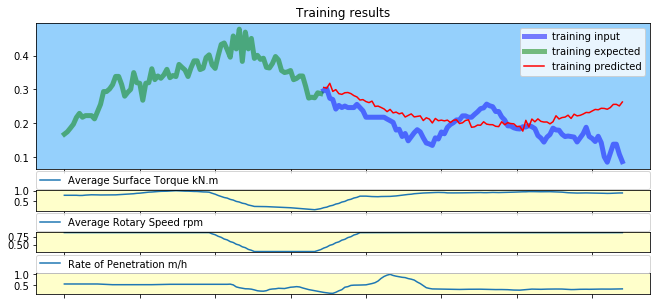

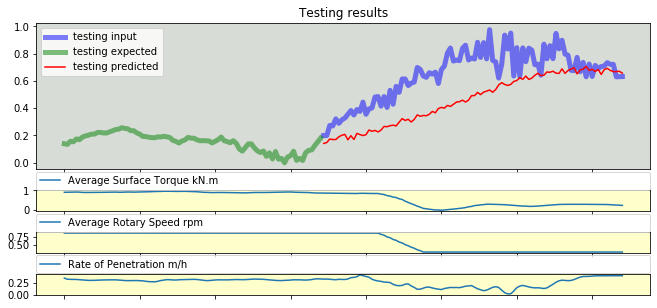

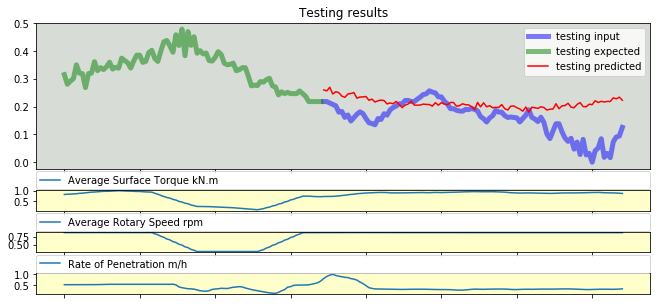

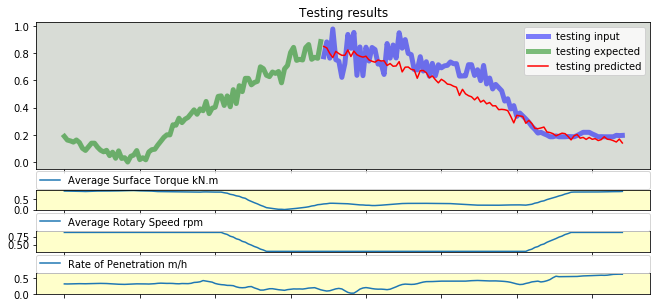

223/223 [==============================] - 0s 798us/step
[500 800 256  20   8   1 136   1  86 100  25  50]
-3.864404444963797


In [6]:
begin = 500
middle = 800
end = 843

model_array = []
val_loss_array = []
hypers_array = []

def expandaxis (var):
    var = np.expand_dims(var, axis=1)
    return var

matrix_size = int(1)


start = np.full((matrix_size,), begin)
stop = np.full((matrix_size,), middle)

inc_layer1 = np.full((matrix_size,), 256) #was234

inc_layer2 = np.full((matrix_size,), 20) #np.full((matrix_size,), 48) #gaussian noise now, divided by 1000.

data_layer1 = np.full((matrix_size,), 8) 
data_layer2 = np.full((matrix_size,), 1) #drop2

dense_layer = np.full((matrix_size,), 136) #was139 #np.arange(139-step, 139+step+1, step) 

range_max =np.full((matrix_size,), 1)  #DISABLED

memory =  np.full((matrix_size,), 86) #np.arange(70, 101, step)  # np.full((matrix_size,), 200) #was86 #np.arange(86-step, 86+step+1, step) 


predictions = np.full((matrix_size,), 100)

drop1 = np.full((matrix_size,), 25)
drop2 = np.full((matrix_size,), 50) #np.random.randint(50,90,size=matrix_size)#


start = expandaxis(start)
stop = expandaxis(stop)
inc_layer1 = expandaxis (inc_layer1)

inc_layer2 = expandaxis (inc_layer2)

data_layer1 = expandaxis (data_layer1)
data_layer2 = expandaxis (data_layer2)

dense_layer = expandaxis (dense_layer)

range_max =expandaxis (range_max)

memory =  expandaxis (memory)

predictions = expandaxis(predictions)
drop1 = expandaxis(drop1)
drop2 = expandaxis(drop2)

hypers = np.hstack([start, stop, inc_layer1,inc_layer2,data_layer1,data_layer2,dense_layer, range_max, memory, predictions, drop1, drop2])

ID = np.random.randint(0,999999)

for i in hypers:
    print("###")
    model, val_loss, scaler1, scaler2, scaler3, scaler4 = hyperparameter(i)
    #model_array.append(model)
    val_loss_array.append(val_loss)
    hypers_array.append(i)
    print (i)
    print (val_loss)
    output = np.append(hypers_array, expandaxis(val_loss_array), axis=1)
    output = pd.DataFrame(output,columns=["start", "stop", "inc_layer1","inc_layer2","data_layer1","data_layer2","dense_layer"," range_max"," memory"," predictions","drop1","drop2", "val loss"])
    try:
        #print (output)
        output.to_csv(str(ID) + " LSTM 21 gauss.csv")
    except:
        print("File opened?")

In [7]:
output.describe()

start   stop  inc_layer1  inc_layer2  data_layer1  data_layer2  \
count    1.0    1.0         1.0         1.0          1.0          1.0   
mean   500.0  800.0       256.0        20.0          8.0          1.0   
std      NaN    NaN         NaN         NaN          NaN          NaN   
min    500.0  800.0       256.0        20.0          8.0          1.0   
25%    500.0  800.0       256.0        20.0          8.0          1.0   
50%    500.0  800.0       256.0        20.0          8.0          1.0   
75%    500.0  800.0       256.0        20.0          8.0          1.0   
max    500.0  800.0       256.0        20.0          8.0          1.0   

       dense_layer   range_max   memory   predictions  drop1  drop2  val loss  
count          1.0         1.0      1.0           1.0    1.0    1.0  1.000000  
mean         136.0         1.0     86.0         100.0   25.0   50.0 -3.864404  
std            NaN         NaN      NaN           NaN    NaN    NaN       NaN  
min          136.0         1.0     86.0         100.0   25.0   50.0 -3.864404  
25%          136.0         1.0     86.0         100.0   25.0   50.0 -3.864404  
50%          136.0         1.0     86.0         100.0   25.0   50.0 -3.864404  
75%          136.0         1.0     86.0         100.0   25.0   50.0 -3.864404  
max          136.0         1.0     86.0         100.0   25.0   50.0 -3.864404

In [8]:
df = df_dl #pd.read_csv('F9ADepth.csv')


In [9]:
valstop = begin + (middle-begin)*0.8

df1 = df[  (df['Measured Depth m'] > begin)  & (df['Measured Depth m'] < valstop )  ]
df2 = df[  (df['Measured Depth m'] > valstop) & (df['Measured Depth m'] < middle)  ]
df3 = df[  (df['Measured Depth m'] > middle) & (df['Measured Depth m'] < end)      ]

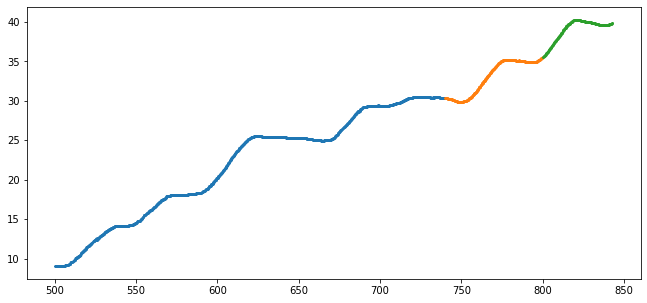

In [10]:
plt.scatter(df1['Measured Depth m'].ffill(),df1['MWD Continuous Inclination dega'].ffill(), s=1)
plt.scatter(df2['Measured Depth m'].ffill(),df2['MWD Continuous Inclination dega'].ffill(), s=1)
plt.scatter(df3['Measured Depth m'].ffill(),df3['MWD Continuous Inclination dega'].ffill(), s=1)

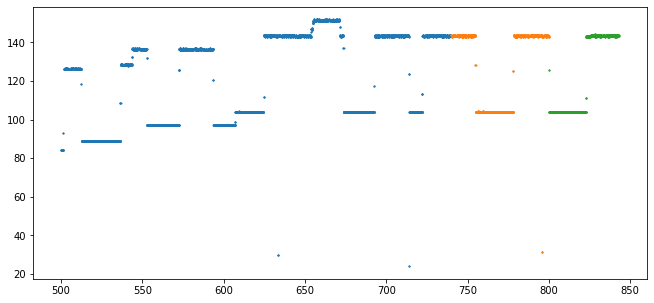

In [11]:
plt.scatter(df1['Measured Depth m'].ffill(),df1['Average Rotary Speed rpm'].ffill(), s=1)
plt.scatter(df2['Measured Depth m'].ffill(),df2['Average Rotary Speed rpm'].ffill(), s=1)
plt.scatter(df3['Measured Depth m'].ffill(),df3['Average Rotary Speed rpm'].ffill(), s=1)

In [12]:
def testmodel(matrix):
    
    [model, start, stop,memory, predictions, scaler1, scaler2, scaler3, scaler4] = matrix


    df = df_dl#pd.read_csv('F9ADepth.csv')

    start = start
    stop = stop
    step = 0.230876

    X = np.arange(start,stop,step)
    X = X.reshape(X.shape[0],1)



    %matplotlib inline
    rcParams['figure.figsize'] = 10, 5

    X = np.arange(start,stop,step)
    X = X.reshape(X.shape[0],1)

    my_data1 = sampling_fix(df, 'MWD Continuous Inclination dega',start,stop,1.7,1,0).predict(X)
    my_data2 = sampling_fix(df, 'Average Surface Torque kN.m',start,stop,1.7,3,0).predict(X)
    my_data3 = sampling_fix(df, 'Average Rotary Speed rpm',start,stop,1.7,3,0).predict(X)
    my_data4 = sampling_fix(df, 'Rate of Penetration m/h',start,stop,0.5,1,0).predict(X)

    dftemp = pd.DataFrame()
    dftemp['dinc'] = my_data1
    dftemp['dinc'] = dftemp['dinc'].diff(1).rolling(3).mean(center=True)

    my_data1 = dftemp['dinc'].ffill().bfill()


    data_array = np.asarray([my_data1, my_data2, my_data3, my_data4])


    my_data1 = my_data1[:,np.newaxis]
    my_data2 = my_data2[:,np.newaxis]
    my_data3 = my_data3[:,np.newaxis]
    my_data4 = my_data4[:,np.newaxis]


    temp_data1 = pd.DataFrame(my_data1.flatten())

    range1 = temp_data1[0].diff(memory+predictions)
    
    
    range2 = np.amax(range1)

    




    my_data1 = scaler1.transform(my_data1)
    my_data2 = scaler2.transform(my_data2)
    my_data3 = scaler3.transform(my_data3)
    my_data4 = scaler4.transform(my_data4)


    X1 = prepareinput(my_data1, memory)


    X2 = prepareinput_nozero(my_data2,memory, predictions)
    X3 = prepareinput_nozero(my_data3,memory, predictions)
    X4 = prepareinput_nozero(my_data4,memory, predictions)


    y_temp = prepareoutput(my_data1, memory, predictions)

    stack = []
    for i in range(memory):
        stack.append(np.roll(my_data1, -i))

    X_temp = np.hstack(stack)



    

    y = y_temp


    
    data_length = len(my_data1)-memory-predictions


    border2 = data_length

    X1_test = X1[:border2]
    X2_test = X2[:border2]
    X3_test = X3[:border2]
    X4_test = X4[:border2]


    y_test = y[:border2]

    X1_test = X1_test.reshape((X1_test.shape[0],X1_test.shape[1],1))
    X2_test = X2_test.reshape((X2_test.shape[0],X2_test.shape[1],1))
    X3_test = X3_test.reshape((X3_test.shape[0],X3_test.shape[1],1))
    X4_test = X4_test.reshape((X4_test.shape[0],X4_test.shape[1],1))
    X_test_con  = np.concatenate((X2_test,  X3_test,  X4_test),  axis=2)
    X_test = [X1_test, X_test_con]

    Xtest = model.predict(X_test)
    
    plotsteps = np.arange(0, int(border2),20)
    for j in plotsteps:
        shape = (7,1)
        fig = plt.figure()
        fig.tight_layout()
        fig.subplots_adjust(hspace = 1)
        ax1 = plt.subplot2grid(shape, (0,0), rowspan=4)    
        ax2 = plt.subplot2grid(shape, (4,0), sharex=ax1)
        ax3 = plt.subplot2grid(shape, (5,0), sharex=ax1)    
        ax4 = plt.subplot2grid(shape, (6,0), sharex=ax1)

        for ax in fig.axes:
            plt.setp(ax.get_xticklabels(), visible=False)

        known_attributes = ['Average Surface Torque kN.m', 'Average Rotary Speed rpm', 'Rate of Penetration m/h']

        i=0
        for axe in fig.axes:
            if i == 0:
                tr = j
                axe.plot(np.arange(memory,memory+predictions,1),y_test[tr],linewidth=5,alpha=0.5,c='b', label='testing input')
                axe.plot(np.arange(0,memory,1),X1_test[tr], linewidth=5,alpha=0.5, c='g' , label="testing expected")
                axe.plot(np.arange(memory,memory+predictions,1),Xtest[tr],c='r', label='testing predicted')
                axe.set_title('Testing results')
                axe.set_facecolor('xkcd:light grey')
                axe.legend()

            else:

                axe.plot(np.arange(0,memory+predictions,1),X_test[1][tr,:,i-1],label=known_attributes[i-1]) 
                axe.set_facecolor('xkcd:ivory')
                axe.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
               ncol=2, mode="expand", borderaxespad=0.)
            i = i + 1
        plt.show()
    
    
    print (np.log(model.evaluate(X_test, y_test)))
    
    return 

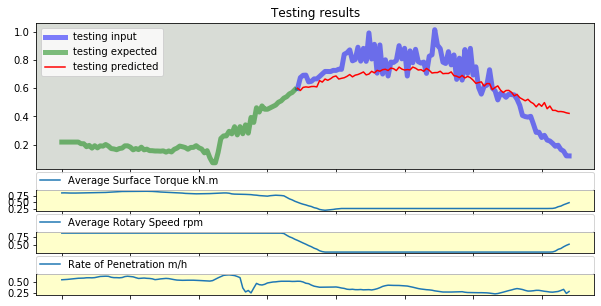

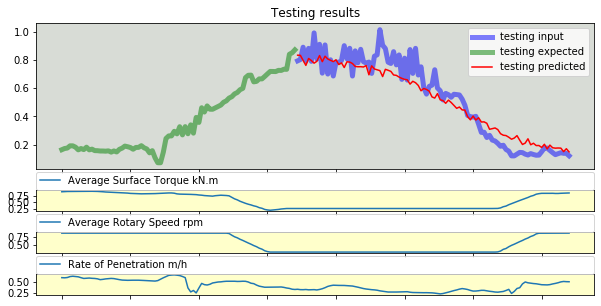

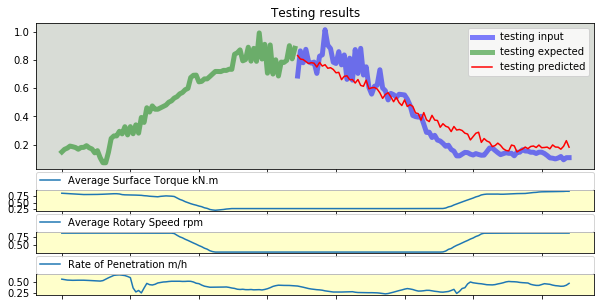

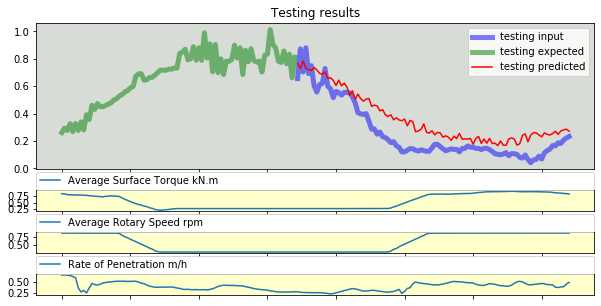

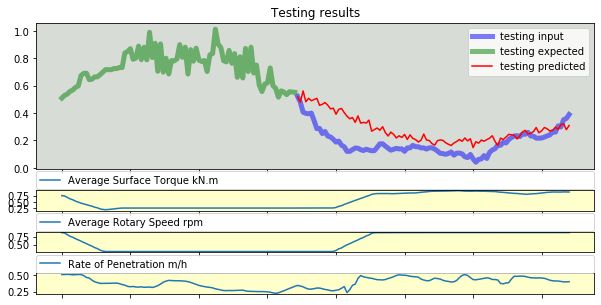

87/87 [==============================] - 0s 173us/step
-4.313529334842093


In [13]:
testmodel([model, middle-20, end, 86, 100, scaler1, scaler2, scaler3, scaler4])


In [14]:
def hairyplot(matrix):
        
    [model, start,mid, stop,memory, predictions, scaler1, scaler2, scaler3, scaler4] = matrix


    df = df_dl#pd.read_csv('F9ADepth.csv')

    start = start
    stop = stop
    step = 0.230876

    X = np.arange(start,stop,step)
    X = X.reshape(X.shape[0],1)

    %matplotlib inline
    rcParams['figure.figsize'] = 10, 5

    X = np.arange(start,stop,step)
    X = X.reshape(X.shape[0],1)

    my_data1 = sampling_fix(df, 'MWD Continuous Inclination dega',start,stop,1.7,1,0).predict(X)
    my_data2 = sampling_fix(df, 'Average Surface Torque kN.m',start,stop,1.7,3,0).predict(X)
    my_data3 = sampling_fix(df, 'Average Rotary Speed rpm',start,stop,1.7,3,0).predict(X)
    my_data4 = sampling_fix(df, 'Rate of Penetration m/h',start,stop,0.5,1,0).predict(X)

    dftemp = pd.DataFrame()
    dftemp['dinc'] = my_data1
    dftemp['dinc'] = dftemp['dinc'].diff(1).rolling(3).mean(center=True)

    my_data1 = dftemp['dinc'].ffill().bfill()

    data_array = np.asarray([my_data1, my_data2, my_data3, my_data4])


    my_data1 = my_data1[:,np.newaxis]
    my_data2 = my_data2[:,np.newaxis]
    my_data3 = my_data3[:,np.newaxis]
    my_data4 = my_data4[:,np.newaxis]


    temp_data1 = pd.DataFrame(my_data1.flatten())

    range1 = temp_data1[0].diff(memory+predictions)
    
    
    range2 = np.amax(range1)


    my_data1 = scaler1.transform(my_data1)
    my_data2 = scaler2.transform(my_data2)
    my_data3 = scaler3.transform(my_data3)
    my_data4 = scaler4.transform(my_data4)


    X1 = prepareinput(my_data1, memory)
    X2 = prepareinput_nozero(my_data2,memory, predictions)
    X3 = prepareinput_nozero(my_data3,memory, predictions)
    X4 = prepareinput_nozero(my_data4,memory, predictions)


    y_temp = prepareoutput(my_data1, memory, predictions)

    stack = []
    for i in range(memory):
        stack.append(np.roll(my_data1, -i))

    X_temp = np.hstack(stack)



   

    y = y_temp

  
    data_length = len(my_data1)-memory-predictions


    border2 = data_length

    X1_test = X1[:border2]
    X2_test = X2[:border2]
    X3_test = X3[:border2]
    X4_test = X4[:border2]


    y_test = y[:border2]

    X1_test = X1_test.reshape((X1_test.shape[0],X1_test.shape[1],1))
    X2_test = X2_test.reshape((X2_test.shape[0],X2_test.shape[1],1))
    X3_test = X3_test.reshape((X3_test.shape[0],X3_test.shape[1],1))
    X4_test = X4_test.reshape((X4_test.shape[0],X4_test.shape[1],1))
    X_test_con  = np.concatenate((X2_test,  X3_test,  X4_test),  axis=2)
    X_test = [X1_test, X_test_con]

    Xtest = model.predict(X_test)
    
    
    d1 = int(((mid-start)/step)*0.8)
    d2 = int((mid-start)/step)
    

    dinc_true = X1_test
    dinc_pred = Xtest

    for i in range(len(Xtest)//20):
      i=i*20
      off = scaler1.inverse_transform(dinc_true[i]).cumsum()[-1]
      plt.plot(np.arange(0,86,1),scaler1.inverse_transform(dinc_true[i]).cumsum())
      plt.plot(np.arange(86,186,1),scaler1.inverse_transform([dinc_pred[i]]).cumsum()+off)
      plt.plot(np.arange(86,186,1),scaler1.inverse_transform([y_test[i]]).cumsum()+off)
      plt.show()

    error=[]
    for i in range(len(Xtest)):
      off = scaler1.inverse_transform(dinc_true[i]).cumsum()[-1]
      error.append(scaler1.inverse_transform([dinc_pred[i]]).cumsum()-scaler1.inverse_transform([y_test[i]]).cumsum())
      


    plt.plot(np.rot90(error,3), alpha=0.03, c="black")
    plt.title("Global error, over whole dataset")
    plt.show()
    
    error5 = np.percentile(error,5,axis=0).flatten()
    error50 = np.percentile(error,50,axis=0).flatten()
    error95 = np.percentile(error,95,axis=0).flatten()

    plt.title("Error in function of prediction distance")
    plt.plot(error95, linewidth=1, c="gray", label="95th percentile")
    plt.plot(error50, linewidth=2, c="black",label="50th percentile")
    plt.plot(error5, linewidth=1, c="gray",label="5th percentile")
    plt.legend()
    plt.show();
    
    plt.title("Average absolute error as a function of prediction distance")
    plt.plot(np.average(np.abs(error), axis=0))
    plt.show()
    
    plt.title("Average absolute error as a function of well depth")
    plt.plot(np.average(np.abs(error), axis=1))
    plt.show()
    
    error = np.asarray(error)
    
    plt.title("Average absolute error of n meters as a function of well depth")
    plt.plot(np.average(np.abs(error[:,:10]), axis=1), c="r", label="first 2 meters")
    plt.plot(np.average(np.abs(error[:,55:65]), axis=1),c="g", label="middle 2 meters")
    plt.plot(np.average(np.abs(error[:,:-10]), axis=1), c="b",label="last 2 meters")
    plt.legend()
    plt.show()


    Xtest = model.predict(X_test)
    
    rcParams['figure.figsize'] = 11, 5

    
    plt.plot(np.rot90(error,3), alpha=0.01, c="black")
    plt.title("Global error, over whole dataset")
    plt.show()
    
    plt.plot(np.rot90(error[:1039-86],3), alpha=0.01, c="black")
    plt.title("Global error, over Training dataset")
    plt.show()
    
    plt.plot(np.rot90(error[1039-86:1299-86],3), alpha=0.03, c="black")
    plt.title("Global error, over Validation dataset")
    plt.show()
    
    
    plt.plot(np.rot90(error[1299-86:],3), alpha=0.05, c="black")
    plt.title("Global error, over Test dataset")
    plt.show()
    
    error5 = np.percentile(error,5,axis=0).flatten()
    error50 = np.percentile(error,50,axis=0).flatten()
    error95 = np.percentile(error,95,axis=0).flatten()

    plt.title("Error in function of prediction distance")
    plt.plot(error95, linewidth=1, c="gray", label="95th percentile")
    plt.plot(error50, linewidth=2, c="black",label="50th percentile")
    plt.plot(error5, linewidth=1, c="gray",label="5th percentile")
    plt.legend()
    plt.grid()
    plt.show();
    
    
    error5 = np.percentile(error[1299-86:],5,axis=0).flatten()
    error50 = np.percentile(error[1299-86:],50,axis=0).flatten()
    error95 = np.percentile(error[1299-86:],95,axis=0).flatten()

    plt.title("Error in function of prediction distance, Test only")
    plt.plot(error95, linewidth=1, c="gray", label="95th percentile")
    plt.plot(error50, linewidth=2, c="black",label="50th percentile")
    plt.plot(error5, linewidth=1, c="gray",label="5th percentile")
    plt.legend()
    plt.grid()
    plt.show();
    
    
    
    plt.title("Average absolute error as a function of prediction distance")
    plt.plot(np.average(np.abs(error), axis=0))
    plt.grid()
    plt.show()
    
    
    
    plt.title("Average absolute error as a function of prediction distance of Train dataset")
    plt.plot(np.average(np.abs(error[:1039-86]), axis=0))
    plt.grid()
    plt.show()
    
    
    plt.title("Average absolute error as a function of prediction distance of Validation dataset")
    plt.plot(np.average(np.abs(error[1039-86:1299-86]), axis=0))
    plt.grid()
    plt.show()
    
    plt.title("Average absolute error as a function of prediction distance of Test dataset")
    plt.plot(np.average(np.abs(error[1299-86:]), axis=0))
    plt.grid()
    plt.show()
    
    
    plt.title("Average absolute error as a function of well depth")
    plt.plot(np.average(np.abs(error), axis=1))
    plt.show()
    
    error = np.asarray(error)
    
    plt.title("Average absolute error of n meters as a function of well depth")
    plt.plot(np.average(np.abs(error[:,:10]), axis=1), c="r", label="first 2 meters")
    plt.plot(np.average(np.abs(error[:,55:65]), axis=1),c="g", label="middle 2 meters")
    plt.plot(np.average(np.abs(error[:,-10:]), axis=1), c="b",label="last 2 meters")
    plt.legend()
    plt.show()
    
    return error

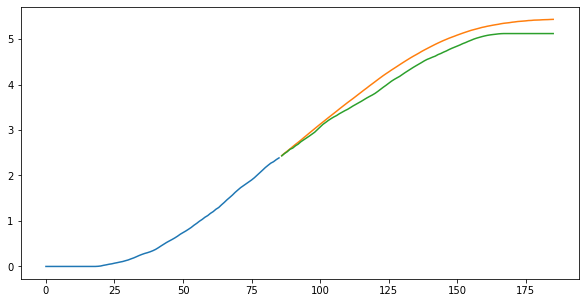

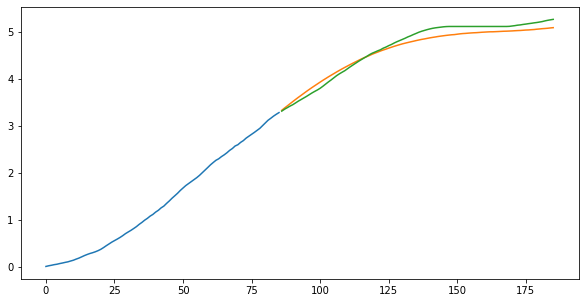

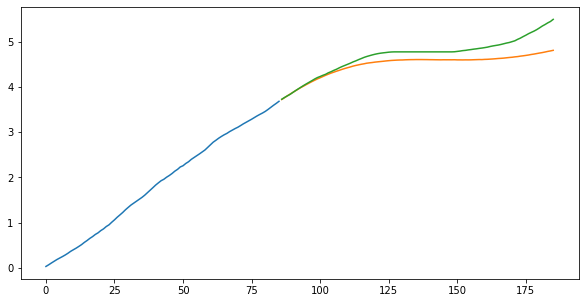

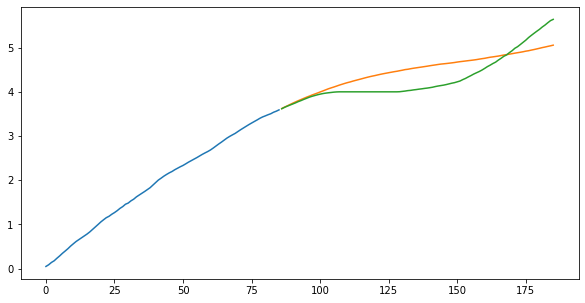

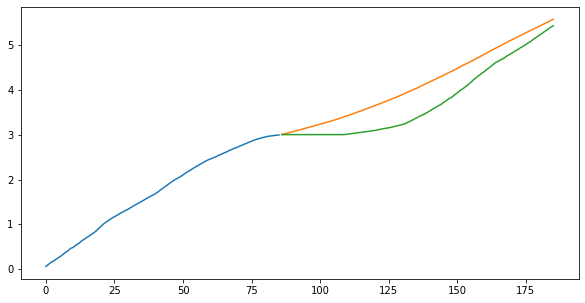

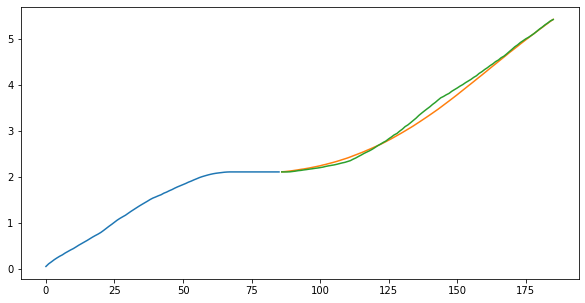

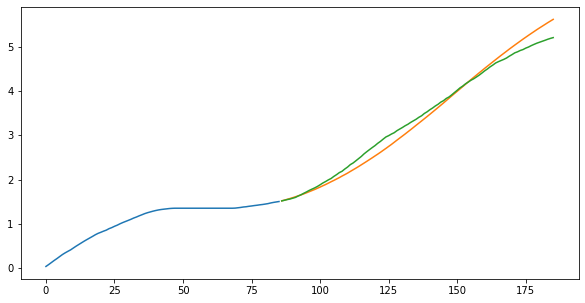

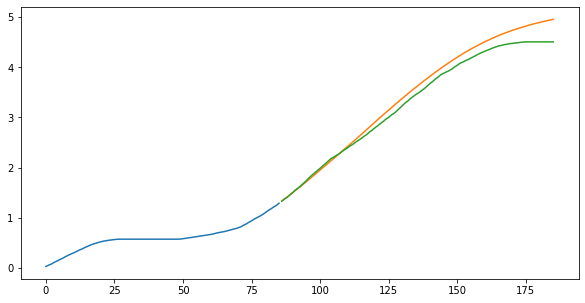

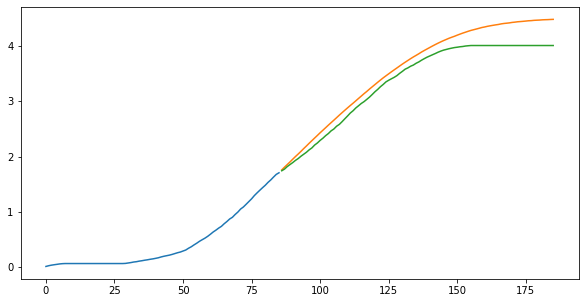

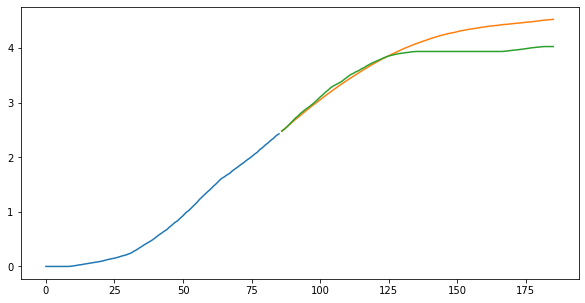

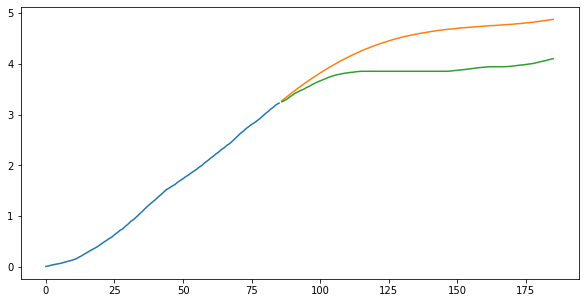

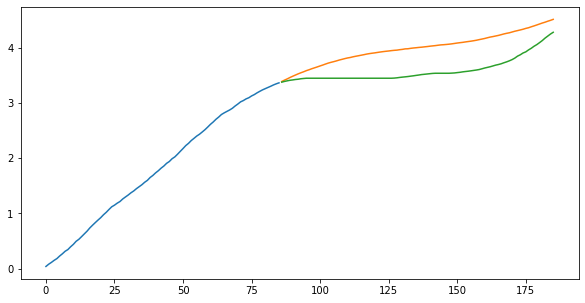

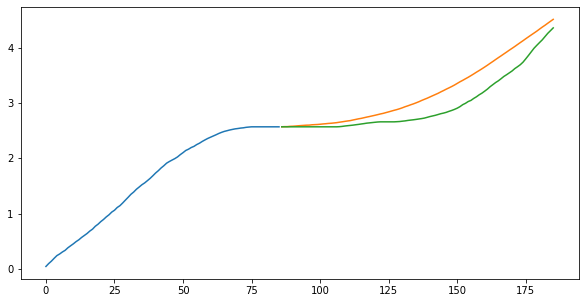

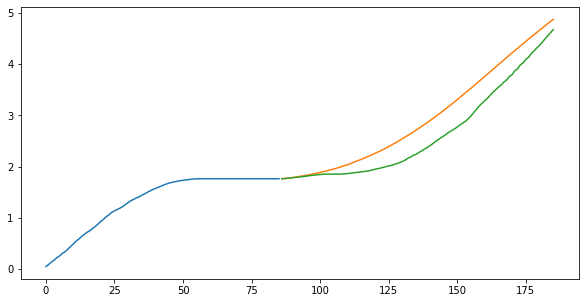

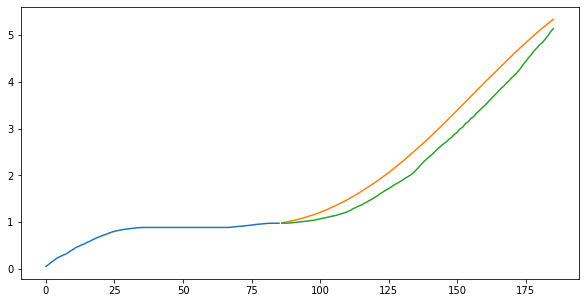

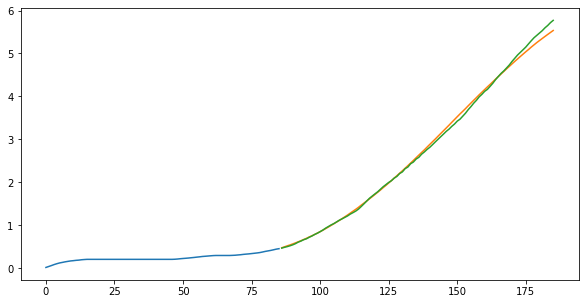

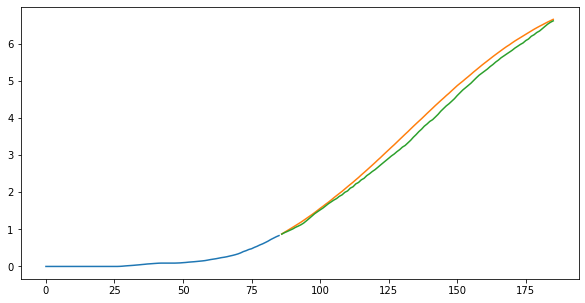

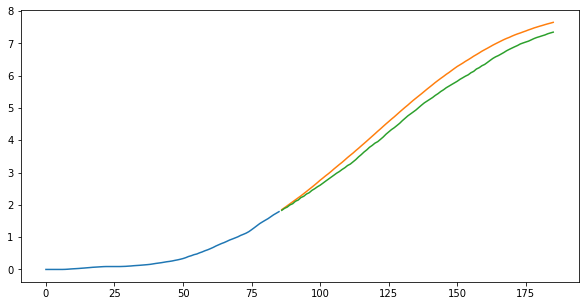

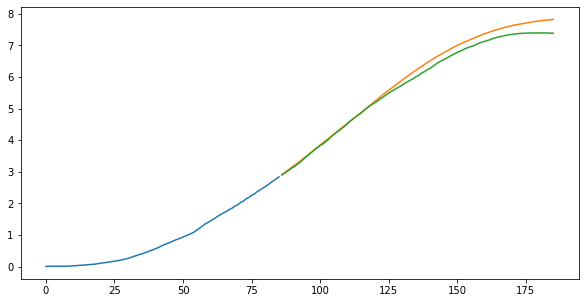

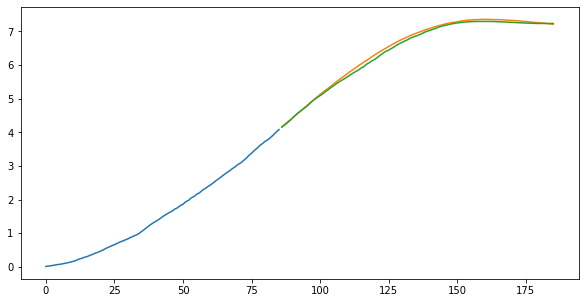

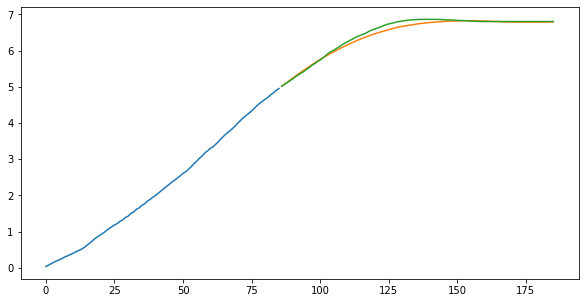

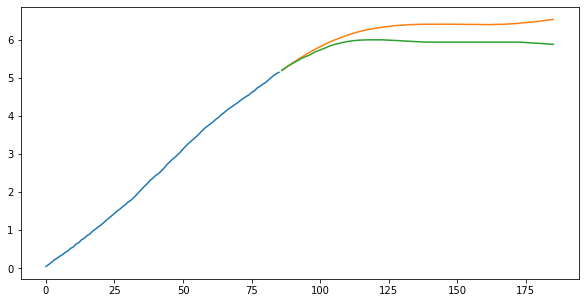

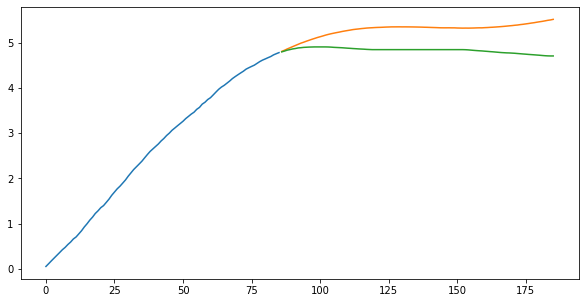

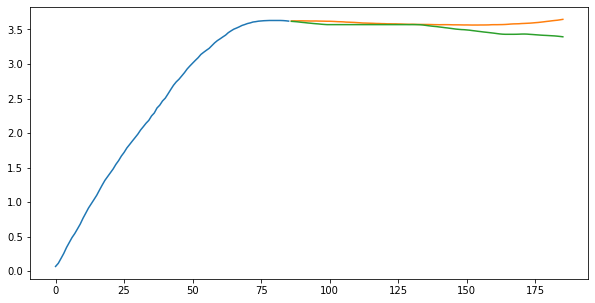

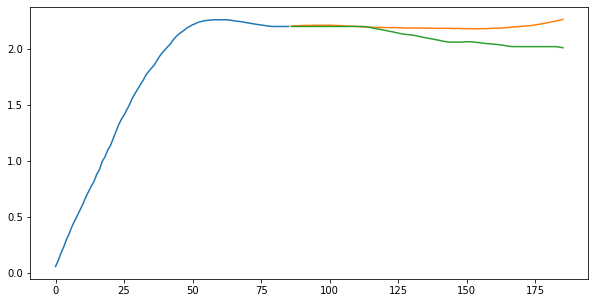

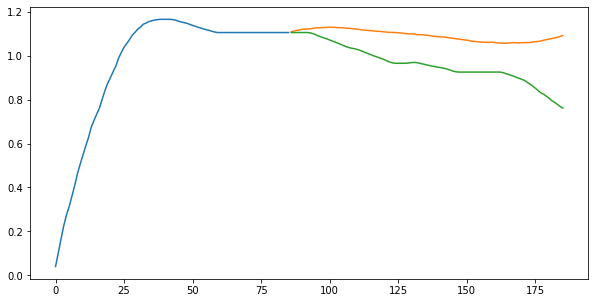

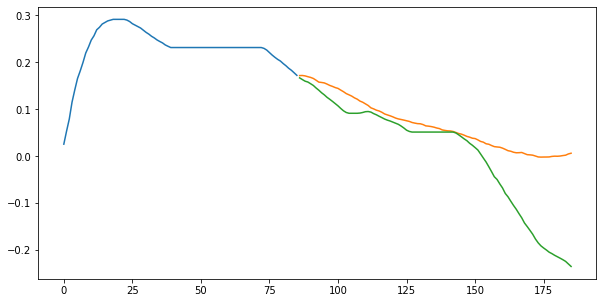

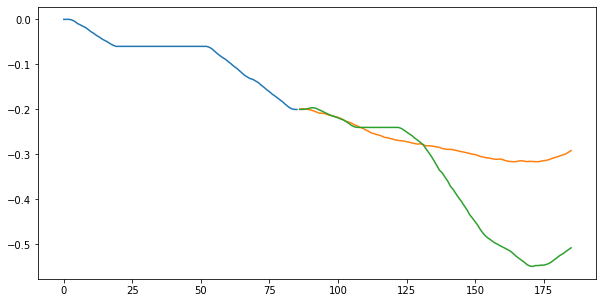

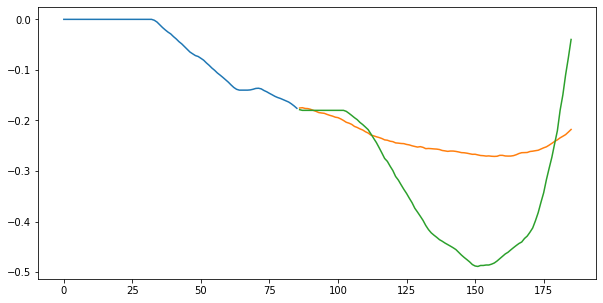

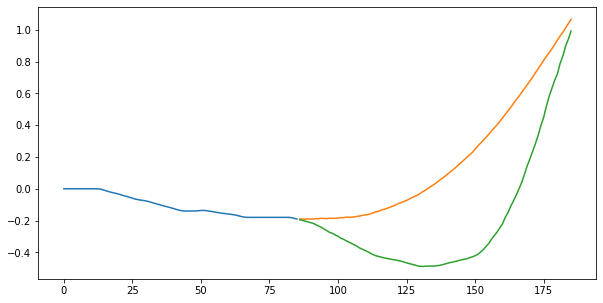

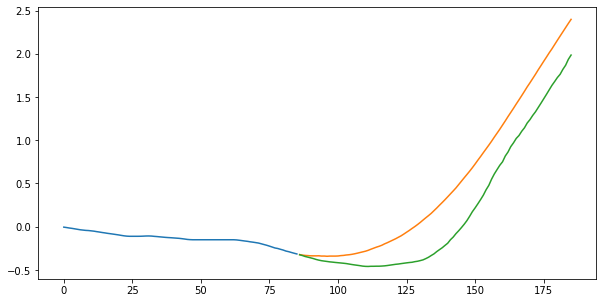

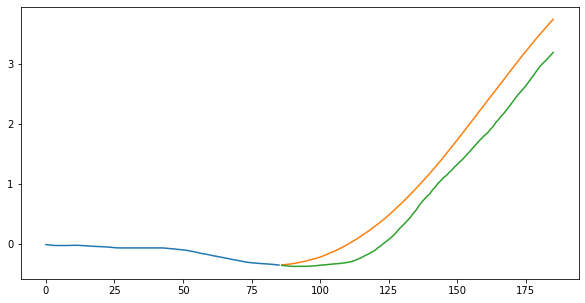

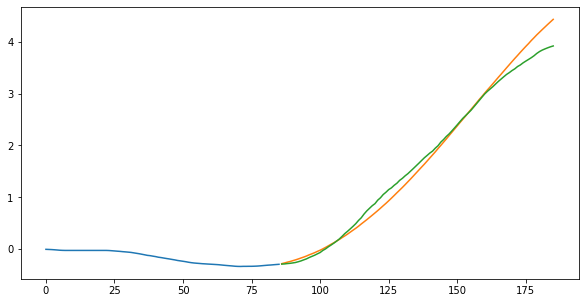

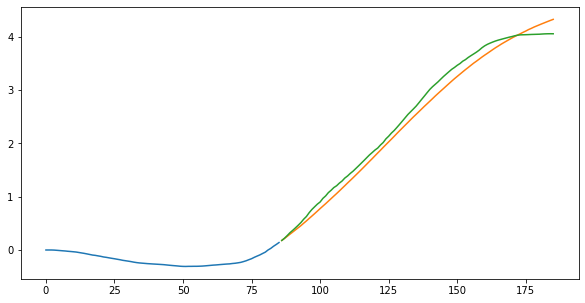

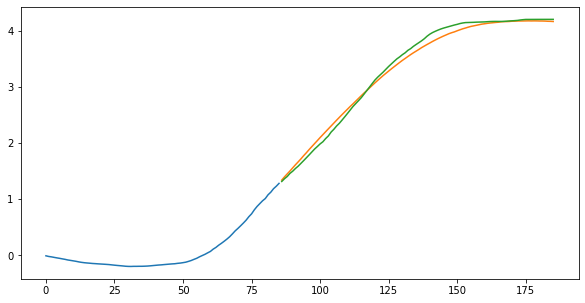

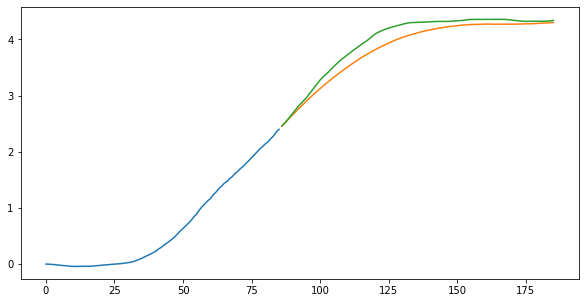

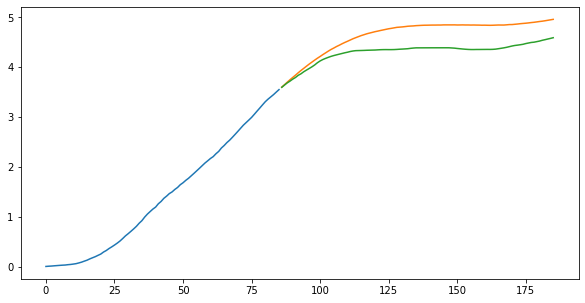

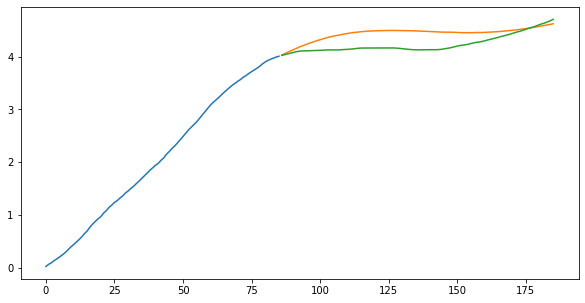

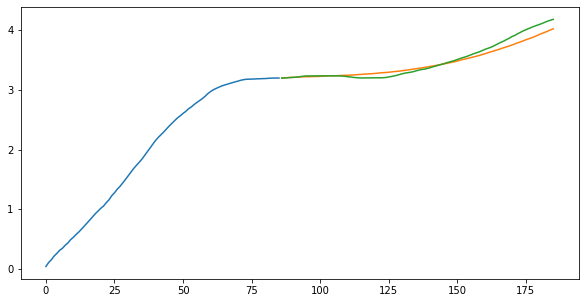

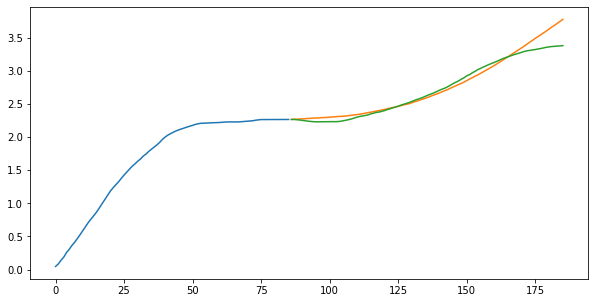

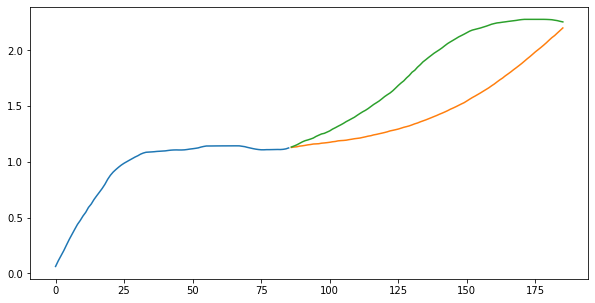

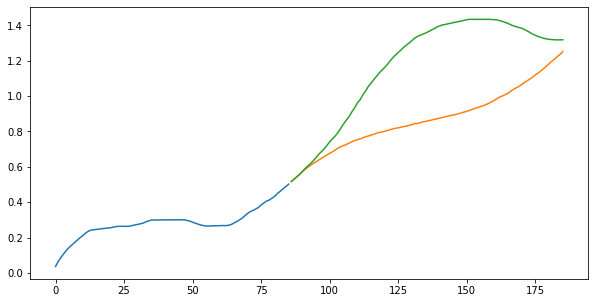

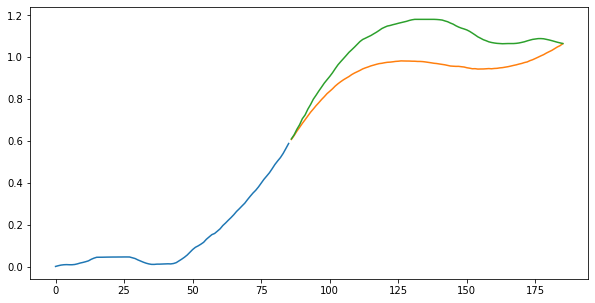

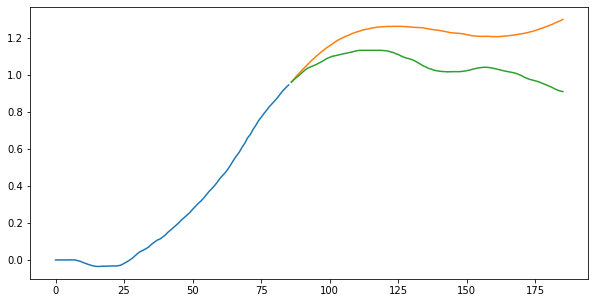

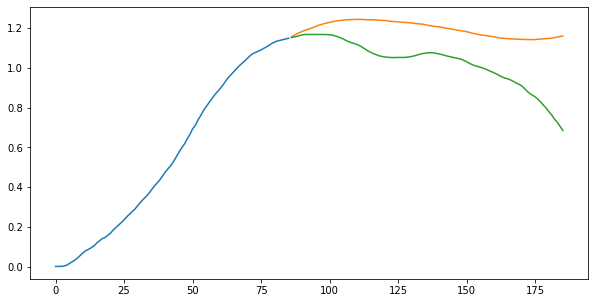

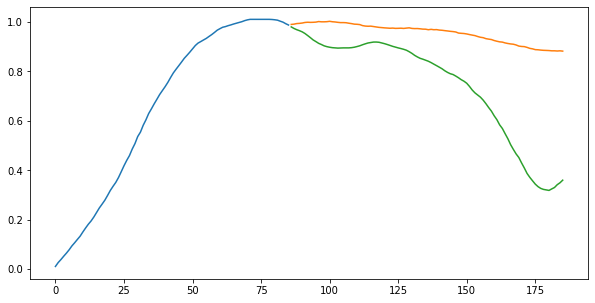

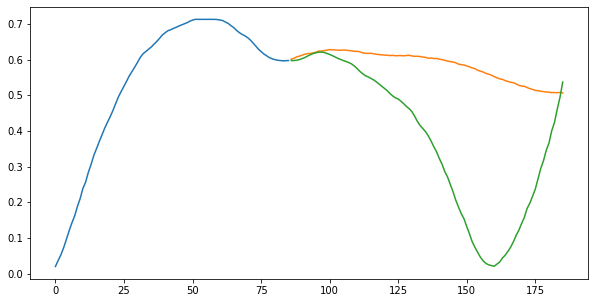

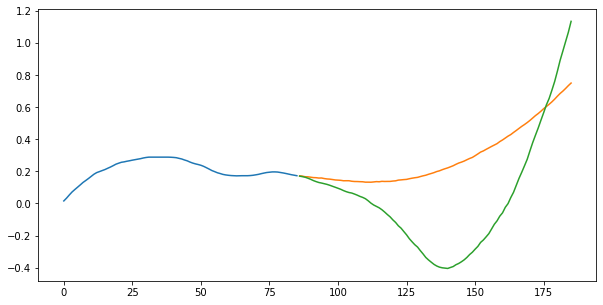

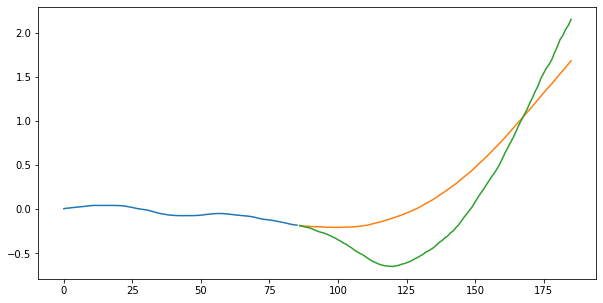

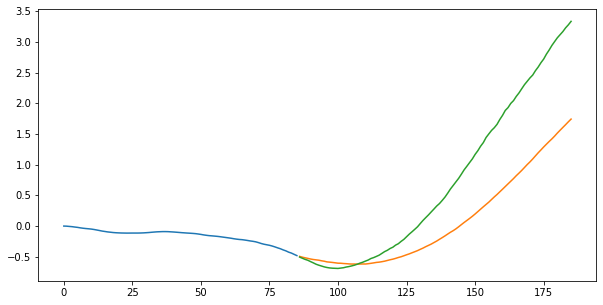

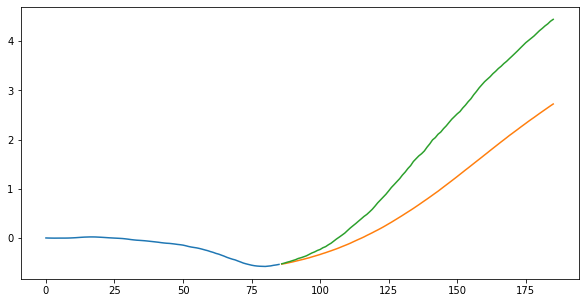

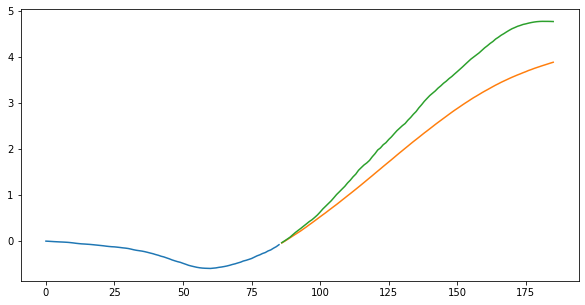

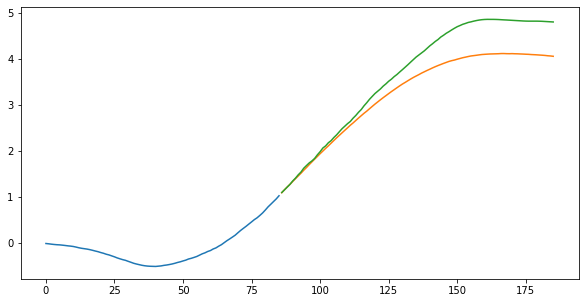

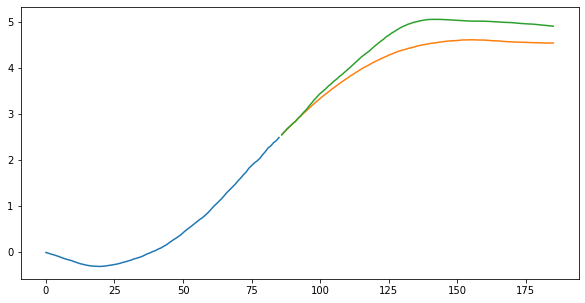

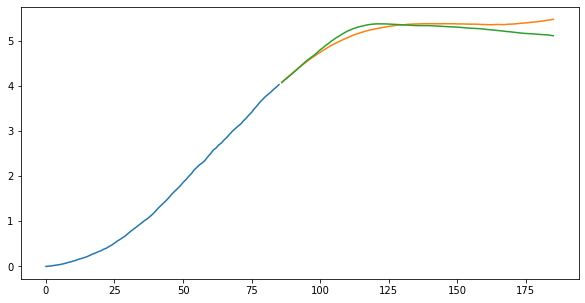

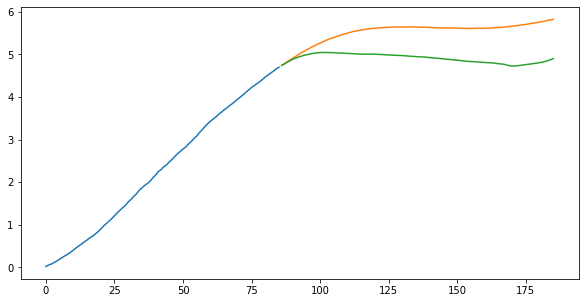

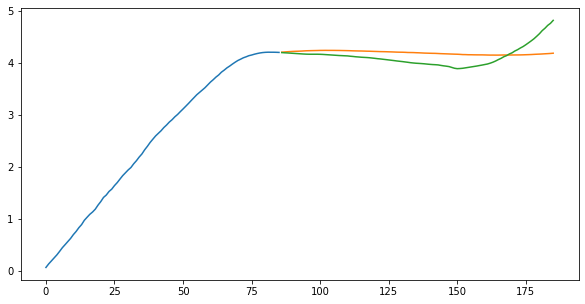

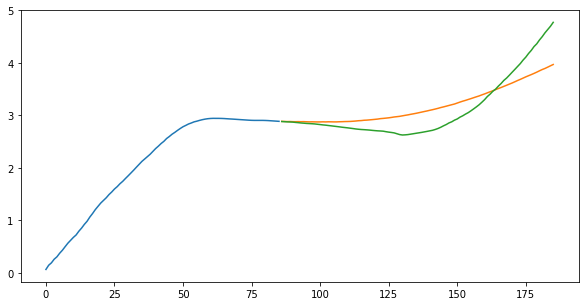

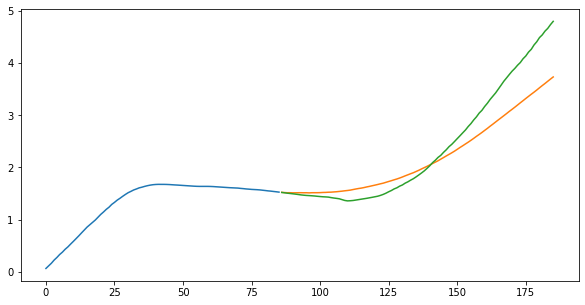

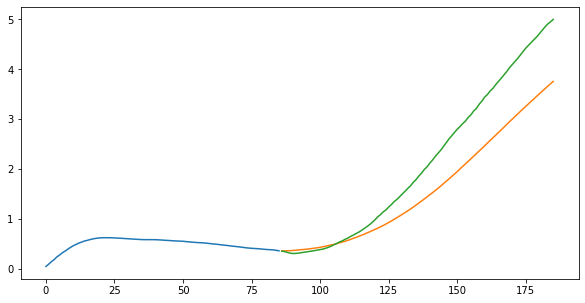

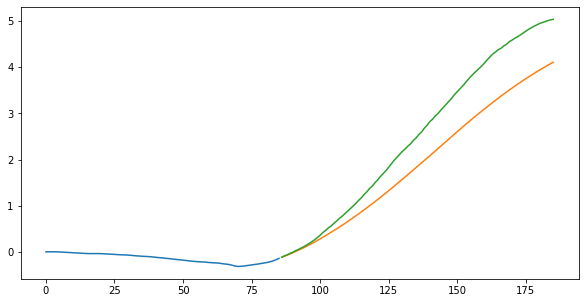

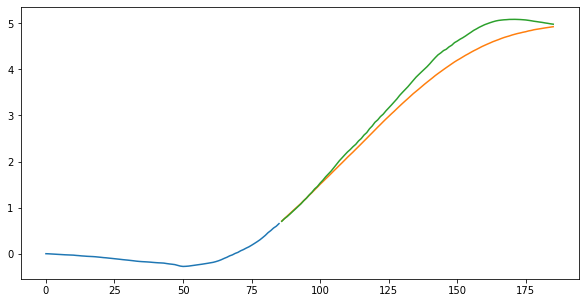

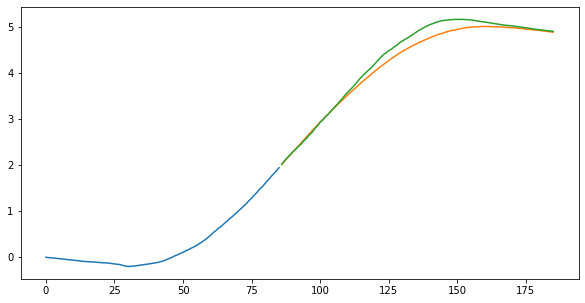

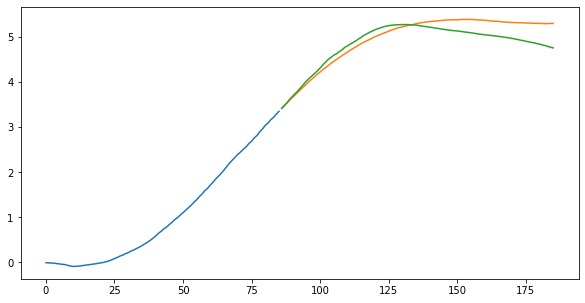

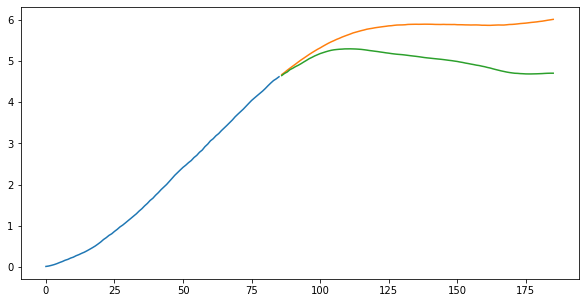

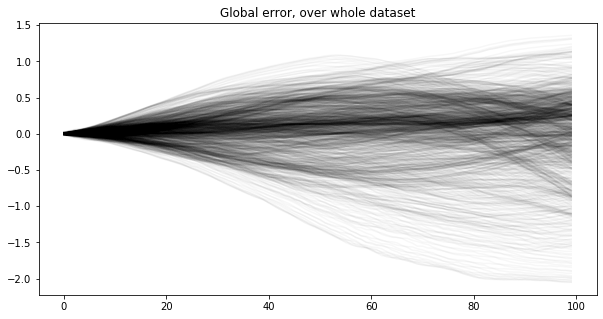

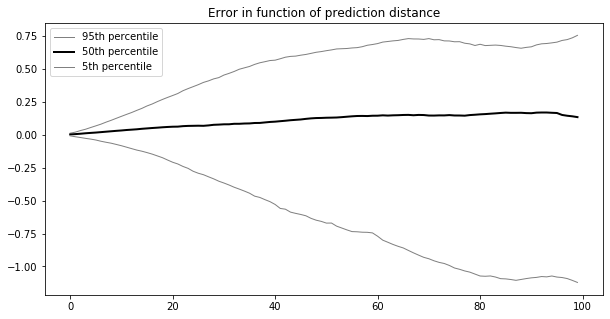

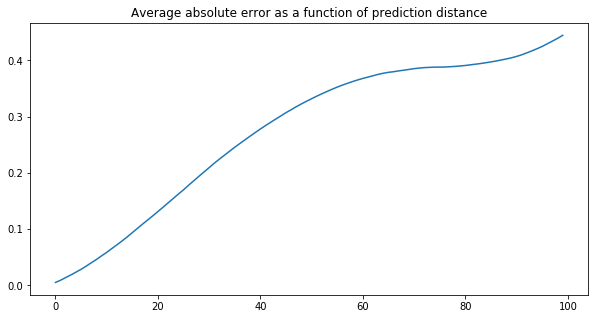

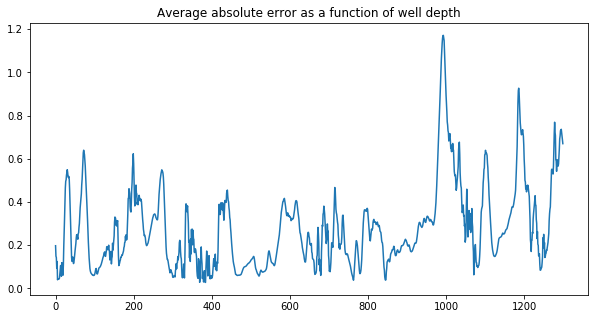

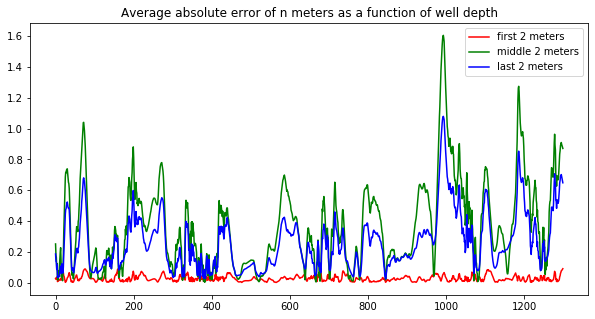

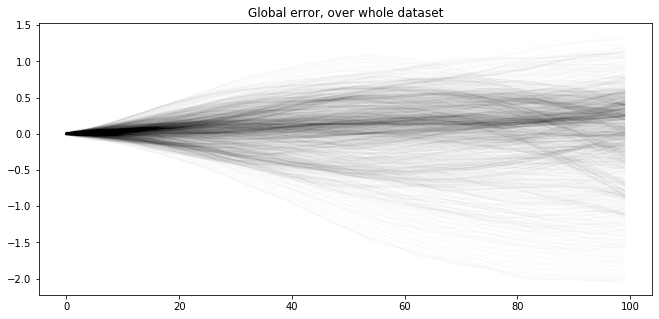

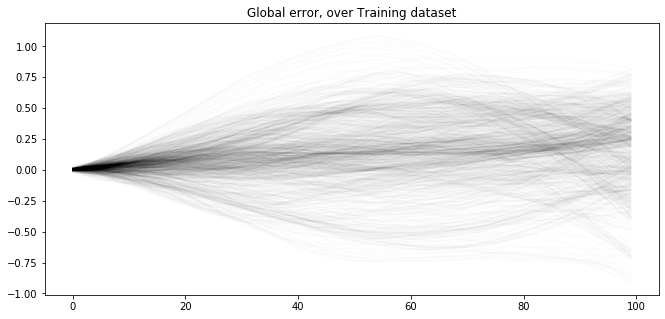

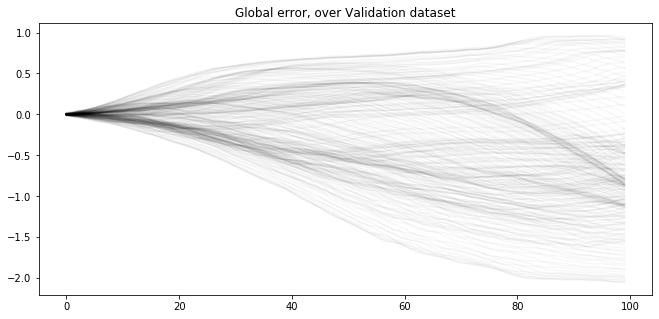

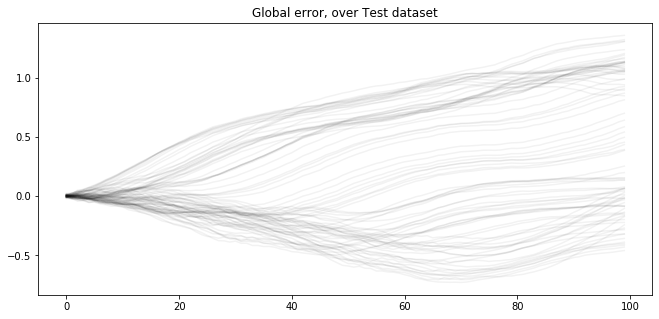

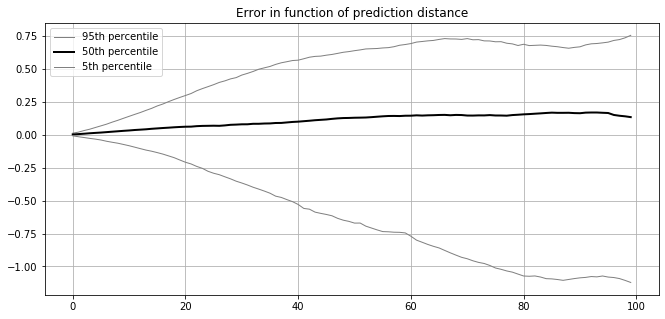

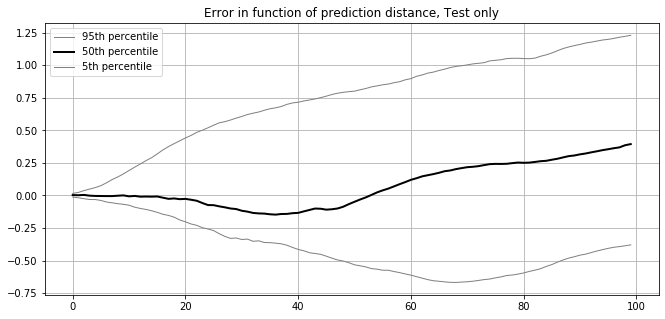

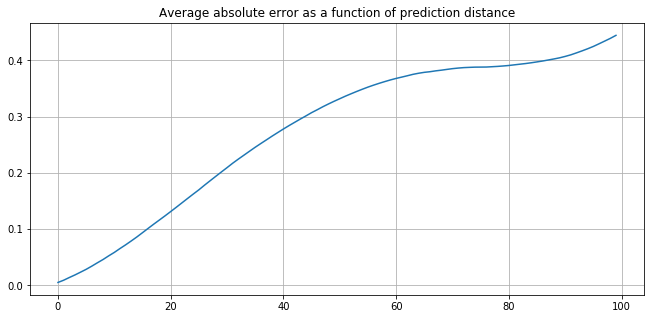

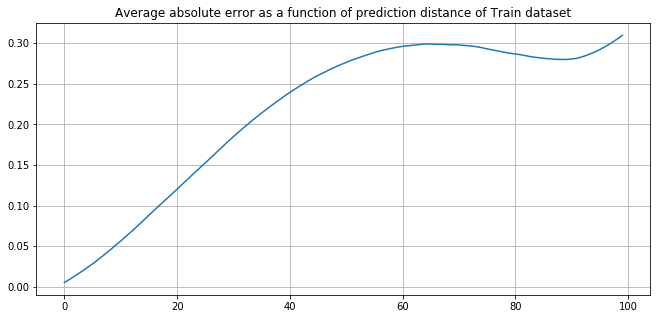

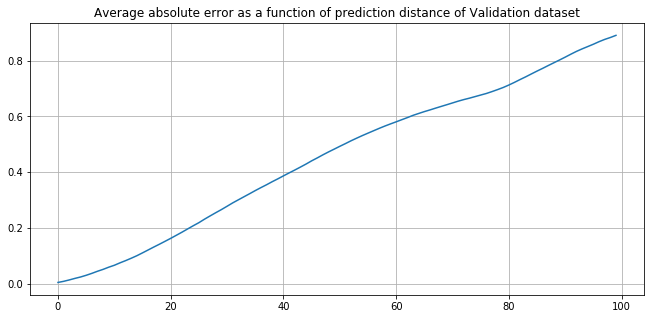

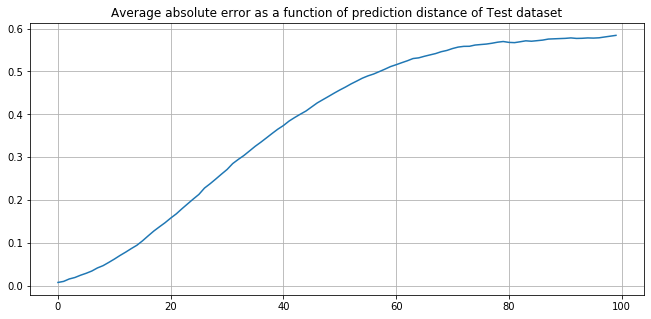

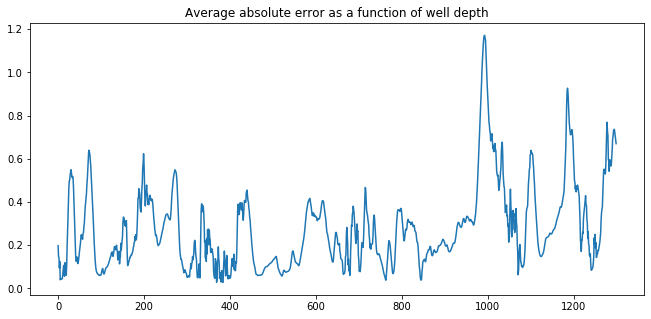

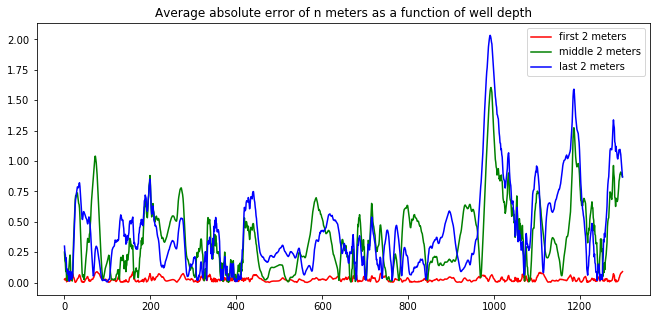

In [15]:
error = hairyplot([model, begin,middle, end, 86, 100, scaler1, scaler2, scaler3, scaler4])

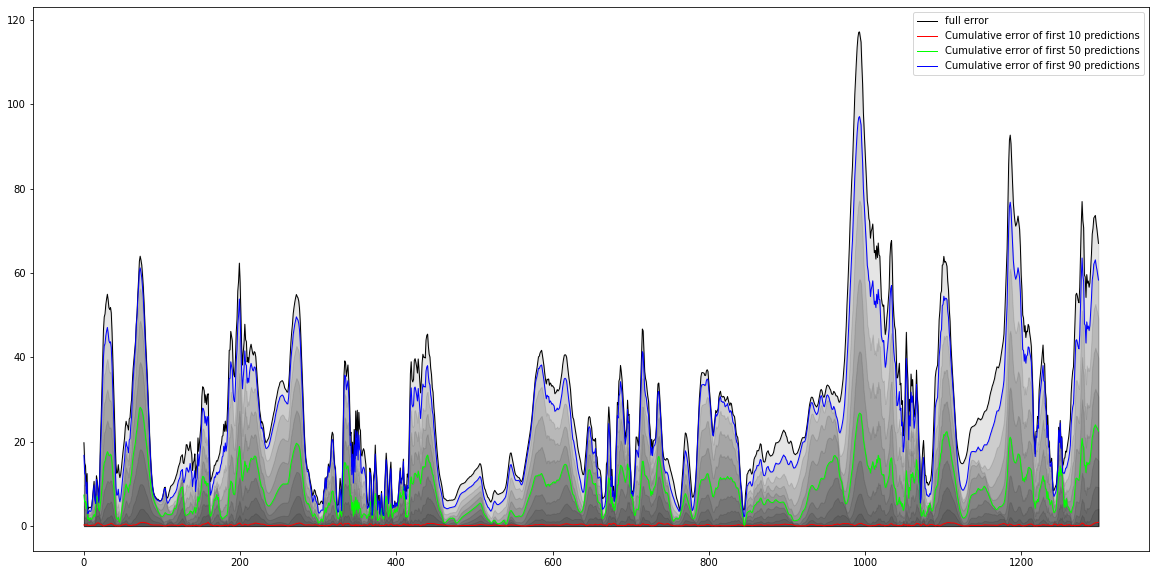

In [16]:

rcParams['figure.figsize'] = 20,10


for i in np.arange(10,101,10):
    _ = plt.fill_between(np.arange(0,len(error),1), np.sum(np.abs(error[:,:i]), axis=1),color='black', alpha='0.1')
_ = plt.plot(np.arange(0,len(error),1), np.sum(np.abs(error[:,:100]), axis=1), c="black",linewidth=1, label="full error")

_ = plt.plot(np.sum(np.abs(error[:,:10]), axis=1), c="r", label="Cumulative error of first 10 predictions",linewidth=1)
_ = plt.plot(np.sum(np.abs(error[:,:50]), axis=1),c="lime", label="Cumulative error of first 50 predictions",linewidth=1)
_ = plt.plot(np.sum(np.abs(error[:,:-10]), axis=1), c="b",label="Cumulative error of first 90 predictions",linewidth=1)
plt.legend()
plt.savefig("chart.png", dpi=400)
plt.show()


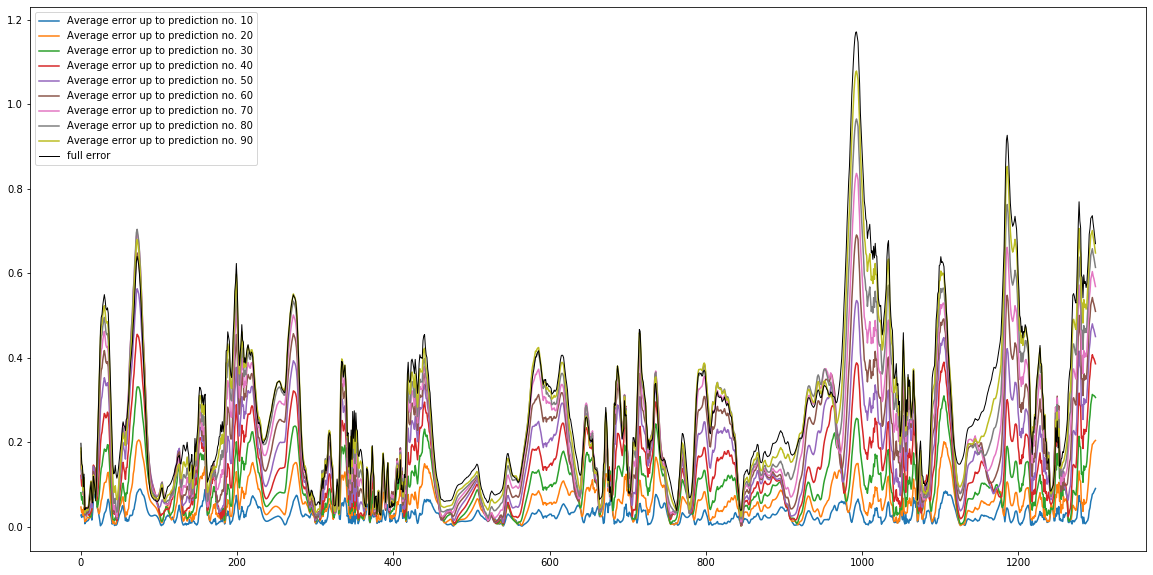

In [17]:

for i in np.arange(10,100,10):

    mylabel = "Average error up to prediction no. " + str(i)
    _ = plt.plot(np.arange(0,len(error),1), np.average(np.abs(error[:,:i]), axis=1), label=mylabel)
    #_ = plt.plot(np.arange(0,len(error),1), np.sum(np.abs(error[:,:100]), axis=1), c="black",linewidth=1, label="full error")

 
_ = plt.plot(np.arange(0,len(error),1), np.average(np.abs(error[:,:100]), axis=1), c="black",linewidth=1, label="full error")


plt.legend()

plt.show()

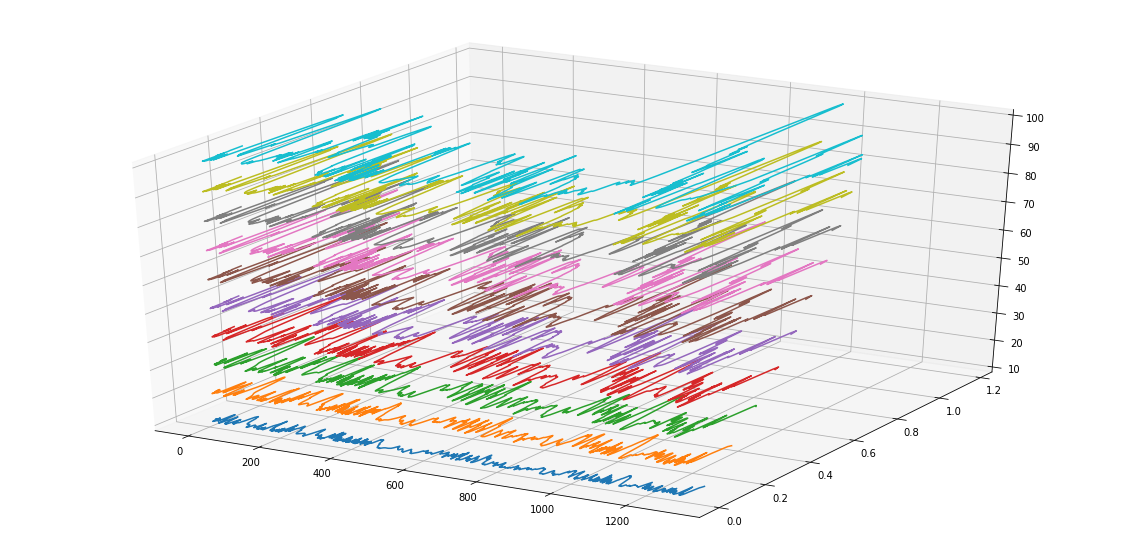

In [18]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')



for i in np.arange(10,101,10):
    _ = ax.plot(xs=np.arange(0,len(error),1), ys=np.average(np.abs(error[:,:i]), axis=1),zs=i)
    


Text(0.5, 1.0, 'Cumulative error in 10% intervals')

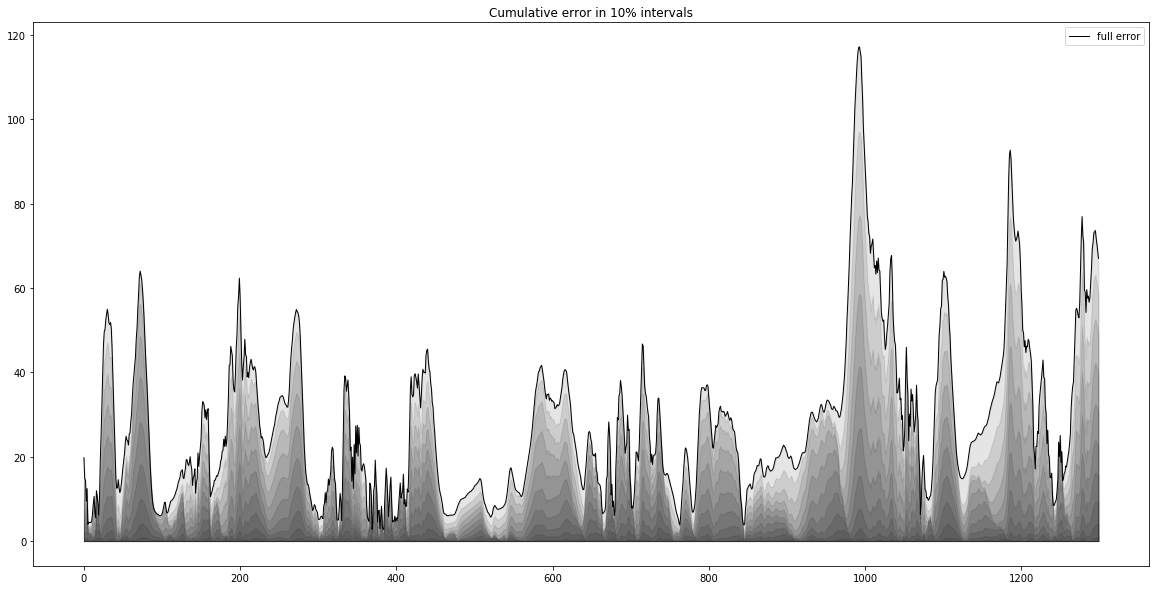

In [19]:
rcParams['figure.figsize'] = 20,10


for i in np.arange(10,101,10):
    _ = plt.fill_between(np.arange(0,len(error),1), np.sum(np.abs(error[:,:i]), axis=1),color='black', alpha='0.1')
_ = plt.plot(np.arange(0,len(error),1), np.sum(np.abs(error[:,:100]), axis=1), c="black",linewidth=1, label="full error")

plt.title("Cumulative error in 10% intervals")
plt.legend()
plt.savefig("chart.png", dpi=400)
plt.show()

Text(0.5, 0, 'prediction distance [m]')

Text(0, 0.5, 'average absolute error [degrees]')

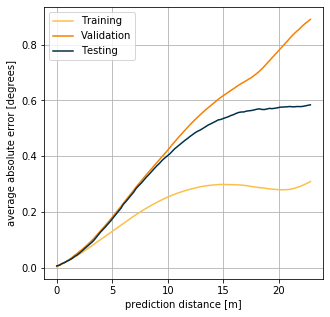

Text(0.5, 0, 'prediction distance [m]')

Text(0, 0.5, 'average absolute error [degrees]')

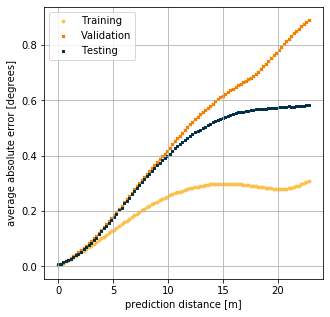

Text(0.5, 1.0, 'Average absolute error as a function of well depth')

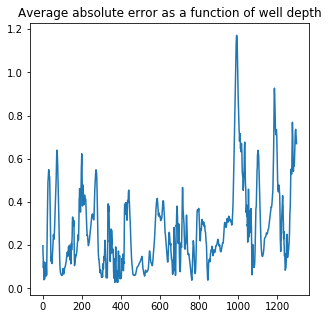

Text(0.5, 1.0, 'Average absolute error of n meters as a function of well depth')

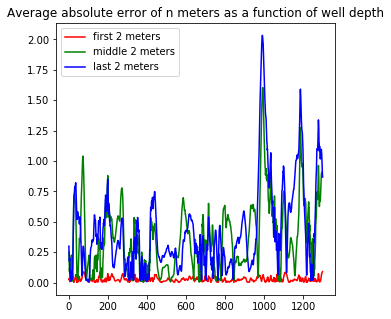

Text(0.5, 1.0, 'Global error, over Test dataset')

Text(0.5, 0, 'prediction distance [m]')

Text(0, 0.5, 'error [degrees]')

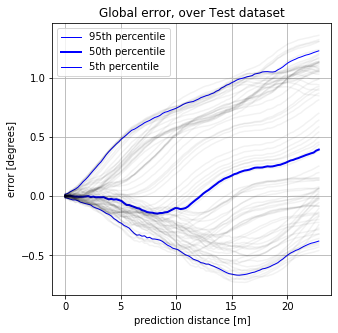

Text(0.5, 1.0, 'Average absolute error as a function of prediction distance of Test dataset')

Text(0.5, 0, 'prediction distance [steps]')

Text(0, 0.5, 'error [degrees]')

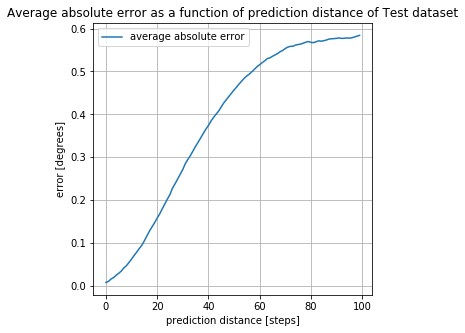

In [20]:
error5 = np.percentile(error[1299-86:],5,axis=0).flatten()
error50 = np.percentile(error[1299-86:],50,axis=0).flatten()
error95 = np.percentile(error[1299-86:],95,axis=0).flatten()
x = np.arange(0,23.0876,0.230876) 

rcParams['figure.figsize'] = 5, 5

plt.plot(x,np.average(np.abs(error[:1039-86]), axis=0), c="#fcbf49", label="Training")
plt.plot(x,np.average(np.abs(error[1039-86:1299-86]), axis=0),c="#f77f00", label="Validation")
plt.plot(x,np.average(np.abs(error[1299-86:]), axis=0), c="#003049", label="Testing")
plt.xlabel("prediction distance [m]")
plt.ylabel("average absolute error [degrees]")
plt.grid()
plt.legend()
plt.savefig("averaga_absolute.png", dpi=300)
plt.show()



plt.scatter(x,np.average(np.abs(error[:1039-86]), axis=0), c="#fcbf49",s=8, marker="o", label="Training")
plt.scatter(x,np.average(np.abs(error[1039-86:1299-86]), axis=0),c="#f77f00",s=8, marker="x", label="Validation")
plt.scatter(x,np.average(np.abs(error[1299-86:]), axis=0), c="#003049",s=8, marker="s", label="Testing")
plt.xlabel("prediction distance [m]")
plt.ylabel("average absolute error [degrees]")
plt.grid()
plt.legend()
plt.savefig("averaga_absolute.png", dpi=300)
plt.show()


plt.title("Average absolute error as a function of well depth")
plt.plot(np.average(np.abs(error), axis=1))
plt.show()

error = np.asarray(error)

plt.title("Average absolute error of n meters as a function of well depth")
plt.plot(np.average(np.abs(error[:,:10]), axis=1), c="r", label="first 2 meters")
plt.plot(np.average(np.abs(error[:,55:65]), axis=1),c="g", label="middle 2 meters")
plt.plot(np.average(np.abs(error[:,-10:]), axis=1), c="b",label="last 2 meters")
plt.legend()
plt.show()



plt.plot(x,error95, linewidth=1, c="blue", label="95th percentile")
plt.plot(x,error50, linewidth=2, c="blue",label="50th percentile")
plt.plot(x,error5, linewidth=1, c="blue",label="5th percentile")
plt.legend()
plt.grid()
plt.plot(x,np.rot90(error[1299-86:],3), alpha=0.05, c="black")
plt.title("Global error, over Test dataset")
plt.xlabel("prediction distance [m]")
plt.ylabel("error [degrees]")
plt.savefig("errorhair.png", dpi=300)
plt.show()

plt.title("Average absolute error as a function of prediction distance of Test dataset")
plt.plot(np.average(np.abs(error[1299-86:]), axis=0), label="average absolute error")
plt.grid()
plt.xlabel("prediction distance [steps]")
plt.ylabel("error [degrees]")
plt.savefig("errorave.png", dpi=300)
plt.legend()
plt.show()

In [21]:
tempdf = pd.DataFrame()

np.save("errorinc2020.npy", error)